In [1]:
import pickle
import cv2
import numpy as np
import os
from tqdm.notebook import trange, tqdm
from os import walk
import glob
from tqdm import tqdm

In [2]:
def load_files(root, mode):

    path = os.path.join(root, mode) 

    filenames = next(walk(path))[1]

    dict_labels = {}
    images_array = []

    for i in range(len(filenames)):  
        img = []
        for images in tqdm(glob.iglob(f'{path+filenames[i]}/*')):
            # check if the image ends with jpg
            if (images.endswith(".jpeg")) or (images.endswith(".jpg")):
                img_temp = images[len(path+filenames[i]+'/'):]
                img_temp = filenames[i]+'/'+img_temp
                img_array = cv2.imread(images)
                img_array = cv2.resize(img_array, dsize=(84, 84))
                images_array.append(img_array)
                img.append(img_temp)

            dict_labels[filenames[i]] = img
    
    y_label = []
    for i, (label, imgs) in enumerate(dict_labels.items()):
        print(i, label, ": number of images: ", len(imgs))
        y = np.full((len(imgs)),i)
        y_label.append(y)
        
    return np.array(images_array).astype('int64'), np.concatenate(y_label,axis=0)

In [3]:
dirc = "/home/atik/Documents/Ocast/borescope-adr-lm2500-data-develop/Processed/wo_Dup"
train_x, train_y = load_files(dirc, "train/")
valid_x, valid_y = load_files(dirc, "test/")

662it [00:02, 239.26it/s]
1053it [00:04, 239.63it/s]
101it [00:00, 264.16it/s]
447it [00:01, 228.48it/s]
667it [00:02, 234.88it/s]
955it [00:03, 268.70it/s]


0 RUB : number of images:  662
1 TBC LOSS : number of images:  1053
2 TEAR : number of images:  101
3 CRACK : number of images:  447
4 DENT_NICK : number of images:  667
5 EROSION : number of images:  955


30it [00:00, 250.81it/s]
77it [00:00, 269.84it/s]
9it [00:00, 273.42it/s]
59it [00:00, 276.50it/s]
98it [00:00, 223.39it/s]
109it [00:00, 266.89it/s]

0 RUB : number of images:  30
1 TBC LOSS : number of images:  77
2 TEAR : number of images:  9
3 CRACK : number of images:  59
4 DENT_NICK : number of images:  98
5 EROSION : number of images:  109


In [4]:
print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)

(3885, 84, 84, 3) (3885,)
(382, 84, 84, 3) (382,)


In [5]:
import numpy as np

import torch
import torchvision

import matplotlib.pyplot as plt

In [6]:
# img_set_x -> images
# img_set_y -> labels
# num_way -> number of classes for episode
# num_shot -> number of examples per class
# num_query -> number of query examples per class 
def extract_episode(img_set_x, img_set_y, num_way, num_shot, num_query):
    # get a list of all unique labels (no repetition)
    unique_labels = np.unique(img_set_y)

    # select num_way classes randomly without replacement
    chosen_labels = np.random.choice(unique_labels, num_way, replace = False)
    # number of examples per selected class (label)
    examples_per_label = num_shot + num_query

    # list to store the episode
    episode = []

    # iterate over all selected labels 
    for label_l in chosen_labels:
        # get all images with a certain label l
        images_with_label_l = img_set_x[img_set_y == label_l]

        # suffle images with label l
        shuffled_images = np.random.permutation(images_with_label_l)

        # chose examples_per_label images with label l
        chosen_images = shuffled_images[:examples_per_label]

        # add the chosen images to the episode
        episode.append(chosen_images)

    # turn python list into a numpy array
    episode = np.array(episode)

    # convert numpy array to tensor of floats
    episode = torch.from_numpy(episode).float()

    # reshape tensor (required)
    episode = episode.permute(0,1,4,2,3)

    # get the shape of the images
    img_dim = episode.shape[2:]
  
    # build a dict with info about the generated episode
    episode_dict = {
        'images': episode, 'num_way': num_way, 'num_shot': num_shot, 
        'num_query': num_query, 'img_dim': img_dim}

    return episode_dict

In [7]:
# episode_dict -> dict with info about the chosen episode
def display_episode_images(episode_dict):
    # number of examples per class 
    examples_per_label = episode_dict['num_shot'] + episode_dict['num_query']

    # total number of images
    num_images = episode_dict['num_way'] * examples_per_label

    # select the images
    images = episode_dict['images'].view(num_images, *episode_dict['img_dim'])

    # create a grid with all the images
    grid_img = torchvision.utils.make_grid(images, nrow = examples_per_label)

    # reshape the tensor and convert to numpy array of integers 
    grid_img = grid_img.permute(1, 2, 0).numpy().astype(np.uint8)

    # chage image from BGR to RGB
    grid_img = cv2.cvtColor(grid_img, cv2.COLOR_BGR2RGB)

    # set a bigger size
    plt.figure(figsize = (80, 8))

    # remove the axis
    plt.axis('off')

    # plot the grid image
    plt.imshow(grid_img)

In [8]:
import logging
import sys

from os import path, mkdir, remove

In [9]:
def euclidean_dist(x, y):
    elements_in_x = x.size(0)
    elements_in_y = y.size(0)

    dimension_elements = x.size(1)

    assert dimension_elements == y.size(1)

    x = x.unsqueeze(1).expand(elements_in_x , elements_in_y, dimension_elements)
    y = y.unsqueeze(0).expand(elements_in_x , elements_in_y, dimension_elements)

    distances = torch.pow(x - y, 2).sum(2)

    return distances

In [10]:
console_logging_format = "%(message)s"

logging.basicConfig(stream = sys.stdout, level = logging.INFO, format = console_logging_format)

print(logging.getLogger().handlers)

[<StreamHandler stdout (NOTSET)>]


In [11]:
def create_logger(log_dir, file_name):
    # get logger
    logger = logging.getLogger()
    
    # remove previous handlers, if they exist
    if bool(logger.handlers):
        logger.handlers.clear()
    
    # create a log directory, if not exists
    if not path.exists(log_dir):
        mkdir(log_dir)
    
    log_file_path = path.join(log_dir, file_name)
    
    # remove old log file (w/ same name)
    if path.exists(log_file_path):
        remove(log_file_path)
    
    # create a new log file
    f = open(log_file_path, 'w+')
    f.close()

    # create a file handler for output file
    file_handler = logging.FileHandler(log_file_path)
    file_handler.setLevel(logging.INFO)
    
    # configure message to log in file
    file_logging_format = "[%(levelname)s] %(asctime)s: %(message)s"
    formatter = logging.Formatter(file_logging_format)
    file_handler.setFormatter(formatter)
    
    # create a console handler
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(logging.INFO)
    
    # configure message to log in console
    console_logging_format = "%(message)s"
    formatter = logging.Formatter(console_logging_format)
    console_handler.setFormatter(formatter)
    
    # add handlers to logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    
    return logger

In [12]:
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

In [13]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

class ProtoNet(nn.Module):
    def __init__(self, encoder):
        super(ProtoNet, self).__init__()
        self.encoder = encoder.cuda()

    def set_forward_loss(self, episode_dict):
        # extract all images 
        images = episode_dict['images'].cuda()
        
        # get episode setup
        num_way = episode_dict['num_way'] # way
        num_shot = episode_dict['num_shot'] # shot
        num_query = episode_dict['num_query'] # number of query images
        
        # from each class, extract num_shot support images
        x_support = images[:, :num_shot] # lines are classes and columns are images
        
        # from each class, extract the remaining images as query images
        x_query = images[:, num_shot:] # lines are classes and columns are images
        
        # create indices from 0 to num_way-1 for classification
        target_inds = torch.arange(0, num_way).view(num_way, 1, 1)
        
        # replicate all indices num_query times (for each query image)
        target_inds = target_inds.expand(num_way, num_query, 1).long()
        
        # convert indices from Tensor to Variable
        target_inds = Variable(target_inds, requires_grad = False).cuda()
        
        # transform x_support into a array in which all images are contiguous
        x_support = x_support.contiguous().view(
            num_way * num_shot, *x_support.size()[2:]) # no more lines and columns
                
        # transform x_query into a array in which all images are contiguous
        x_query = x_query.contiguous().view(
            num_way * num_query, *x_query.size()[2:]) # no more lines and columns

        # join all images into a single contiguous array 
        x = torch.cat([x_support, x_query], 0)
        
        # encode all images
        z = self.encoder.forward(x) # embeddings
        
        # compute class prototypes
        z_dim = z.size(-1)
        z_proto = z[:(num_way * num_shot)].view(num_way, num_shot, z_dim).mean(1)
        
        # get the query embeddings
        z_query = z[(num_way * num_shot):]

        # compute distance between query embeddings and class prototypes
        dists = euclidean_dist(z_query, z_proto)
        
        # compute the log probabilities
        log_p_y = F.log_softmax(-dists, dim = 1).view(num_way, num_query, -1)
        
        # compute the loss
        loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
        
        # get the predicted labels for each query
        _, y_hat = log_p_y.max(2) # lines are classes and columns are query embeddings
        
        # compute the accuracy
        acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
        
        # return output: loss, acc and predicted value
        return loss_val, {
            'loss': loss_val.item(), 'acc': acc_val.item(), 'y_hat': y_hat}

In [14]:
# function to load the model structure
def load_protonet(x_dim, hid_dim, z_dim):
    # define a convolutional block
    def conv_block(layer_input, layer_output): 
        conv = nn.Sequential(
            nn.Conv2d(layer_input, layer_output, 3, padding=1),
            nn.BatchNorm2d(layer_output), nn.ReLU(), 
            nn.MaxPool2d(2))

        return conv
  
    # create the encoder to the embeddings for the images
    # the encoder is made of four conv blocks 
    encoder = nn.Sequential(
        conv_block(x_dim[0], hid_dim), conv_block(hid_dim, hid_dim), 
        conv_block(hid_dim, hid_dim), conv_block(hid_dim, z_dim), Flatten())
  
    return ProtoNet(encoder)

In [15]:
import torch.nn as nn
import torch.optim as optim

import numpy as np
from math import fsum

from tqdm.notebook import trange
from os import path, mkdir

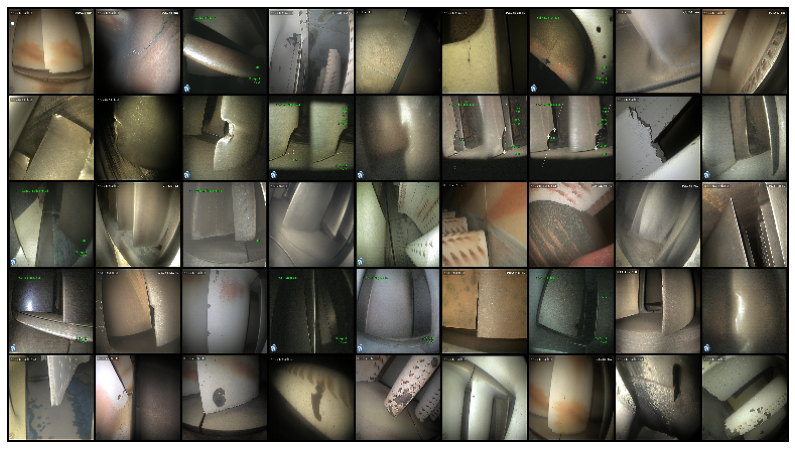

In [16]:
episode_dict = extract_episode(train_x, train_y, num_way = 5, num_shot = 5, num_query = 4)
display_episode_images(episode_dict)

In [17]:
results_dir = path.join(dirc, 'results_ocast')

if not path.exists(results_dir):
    mkdir(results_dir)

In [18]:
best_epoch = {
    'number': -1,
    'loss': np.inf,
    'acc': 0}

config = {
    'results_dir': results_dir,
    'learning_rate': 0.001,
    'decay_every': 20,
    'patience': 30,
    'best_epoch': best_epoch,
    'wait': 0,
    'stop': False}

In [19]:
# images have 3 color channels and are 84 x 84
# Convolutional blocks have 64 filters
model = load_protonet(x_dim  = (3, 84, 84), hid_dim = 64, z_dim = 64)

In [20]:
# model -> model structure
# config -> dict with some hyperparameters and important configs
# train_data -> train set, num_way, num_shot, num_query etc
# valid_data -> validation set, num_way, num_shot, num_query etc
def train(model, config, train_data, valid_data, logger):
    # set Adam optimizer with an initial learning rate
    optimizer = optim.Adam(
        model.parameters(), lr = config['learning_rate'])

    # schedule learning rate to be cut in half every 2000 episodes
    scheduler = optim.lr_scheduler.StepLR(
        optimizer, config['decay_every'], gamma = 0.5, last_epoch = -1)

    # set model to training mode
    model.train()

    # number of epochs so far
    epochs_so_far = 0

    # train until early stopping says so
    # or until the max number of epochs is not achived 
    while epochs_so_far < train_data['max_epoch'] and not config['stop']:
        epoch_loss = 0.0
        epoch_acc = 0.0

        logger.info('==> Epoch %d' % (epochs_so_far + 1))

        logger.info('> Training')

        # do epoch_size classification tasks to train the model
        for episode in trange(train_data['epoch_size']):
            # get the episode dict
            episode_dict = extract_episode(
              train_data['train_x'], train_data['train_y'], train_data['num_way'], 
              train_data['num_shot'], train_data['num_query'])

            optimizer.zero_grad()

            # classify images and get the loss and the acc of the curr episode
            loss, output = model.set_forward_loss(episode_dict)

            # acumulate the loss and the acc
            epoch_loss += output['loss']
            epoch_acc += output['acc']

            # update the model parameters (weights and biases)
            loss.backward()
            optimizer.step()

        # average the loss and the acc to get the epoch loss and the acc
        epoch_loss = epoch_loss / train_data['epoch_size']
        epoch_acc = epoch_acc / train_data['epoch_size']

        # output the epoch loss and the epoch acc
        logger.info('Loss: %.4f / Acc: %.2f%%' % (epoch_loss, (epoch_acc * 100)))

        # do one epoch of evaluation on the validation test
        evaluate_valid(model, config, valid_data, epochs_so_far + 1, logger)

        # increment the number of epochs
        epochs_so_far += 1

        # tell the scheduler to increment its counter
        scheduler.step()

    # get dict with info about the best epoch
    best_epoch = config['best_epoch']

    # at the end of the training, output the best loss and the best acc
    logger.info('Best loss: %.4f / Best Acc: %.2f%%' 
          % (best_epoch['loss'], (best_epoch['acc'] * 100)))

    # save dict with info about the best epoch
    with open(path.join(config['results_dir'], 'best_epoch.pkl'), 'wb') as f:
        pickle.dump(best_epoch, f, pickle.HIGHEST_PROTOCOL)

In [21]:
# model -> model structure
# config -> dict with some hyperparameters and important configs
# valid_data -> validation set, num_way, num_shot, num_query etc
# epoch -> number of the respective training epoch
def evaluate_valid(model, config, valid_data, curr_epoch, logger):
    # set model to evaluation mode
    model.eval()

    valid_loss = 0.0
    valid_acc = 0.0

    logger.info('> Validation')

    # do epoch_size classification tasks to evaluate the model
    for episode in trange(valid_data['epoch_size']):
        # get the episode dict
        episode_dict = extract_episode(
            valid_data['valid_x'], valid_data['valid_y'], valid_data['num_way'], 
            valid_data['num_shot'], valid_data['num_query'])

        # classify images and get the loss and the acc of the curr episode
        _, output = model.set_forward_loss(episode_dict)

        # acumulate the loss and the acc
        valid_loss += output['loss']
        valid_acc += output['acc']
  
    # average the loss and the acc to get the valid loss and the acc
    valid_loss = valid_loss / valid_data['epoch_size']
    valid_acc = valid_acc / valid_data['epoch_size']

    # output the valid loss and the valid acc
    logger.info('Loss: %.4f / Acc: %.2f%%' % (valid_loss, (valid_acc * 100)))

    # implement early stopping mechanism
    # check if valid_loss is the best so far
    if config['best_epoch']['loss'] > valid_loss:
        # if true, save the respective train epoch
        config['best_epoch']['number'] = curr_epoch

        # save the best loss and the respective acc
        config['best_epoch']['loss'] = valid_loss
        config['best_epoch']['acc'] = valid_acc

        # save the model with the best loss so far
        model_file = path.join(config['results_dir'], 'best_model.pth')
        torch.save(model.state_dict(), model_file)

        logger.info('=> This is the best model so far! Saving...')

        # set wait to zero
        config['wait'] = 0
    else:
        # if false, increment the wait
        config['wait'] += 1

        # when the wait is bigger than the patience
        if config['wait'] > config['patience']:
            # the train has to stop
            config['stop'] = True

            logger.info('Patience was exceeded... Stopping...')

In [23]:
train_data = {
    'train_x': train_x,
    'train_y': train_y,
    'num_way': 5,
    'num_shot': 5,
    'num_query': 4,
    'max_epoch': 1000,
    'epoch_size': 100}

valid_data = {
    'valid_x': valid_x,
    'valid_y': valid_y,
    'num_way': 5,
    'num_shot': 5,
    'num_query': 4,
    'epoch_size': 100}

train_logger = create_logger(path.join(results_dir, 'logs'), 'train.log')

train_time = %timeit -n1 -r1 -q -o train(model, config, train_data, valid_data, train_logger)

train_logger.info('Time taken: ' + str(train_time))

==> Epoch 1
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 19.9019 / Acc: 29.00%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 4.3848 / Acc: 39.15%
=> This is the best model so far! Saving...
==> Epoch 2
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.6899 / Acc: 36.05%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2640 / Acc: 48.95%
=> This is the best model so far! Saving...
==> Epoch 3
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3389 / Acc: 43.65%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1769 / Acc: 49.65%
=> This is the best model so far! Saving...
==> Epoch 4
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.3091 / Acc: 43.15%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1587 / Acc: 49.70%
=> This is the best model so far! Saving...
==> Epoch 5
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2211 / Acc: 48.30%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0392 / Acc: 57.30%
=> This is the best model so far! Saving...
==> Epoch 6
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1718 / Acc: 50.30%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0264 / Acc: 58.00%
=> This is the best model so far! Saving...
==> Epoch 7
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1708 / Acc: 51.50%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0749 / Acc: 55.00%
==> Epoch 8
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0628 / Acc: 54.85%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0528 / Acc: 56.30%
==> Epoch 9
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.1076 / Acc: 54.55%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0397 / Acc: 56.55%
==> Epoch 10
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0806 / Acc: 54.95%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0388 / Acc: 58.45%
==> Epoch 11
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0088 / Acc: 59.25%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0113 / Acc: 59.65%
=> This is the best model so far! Saving...
==> Epoch 12
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0249 / Acc: 59.70%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9747 / Acc: 61.50%
=> This is the best model so far! Saving...
==> Epoch 13
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0287 / Acc: 59.05%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0134 / Acc: 61.75%
==> Epoch 14
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0143 / Acc: 58.75%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9816 / Acc: 61.30%
==> Epoch 15
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9787 / Acc: 61.50%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9287 / Acc: 60.60%
=> This is the best model so far! Saving...
==> Epoch 16
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9665 / Acc: 61.90%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9504 / Acc: 63.75%
==> Epoch 17
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9726 / Acc: 61.60%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9685 / Acc: 61.75%
==> Epoch 18
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9031 / Acc: 65.20%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9389 / Acc: 61.60%
==> Epoch 19
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9177 / Acc: 65.50%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0417 / Acc: 58.85%
==> Epoch 20
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9592 / Acc: 62.00%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9371 / Acc: 64.70%
==> Epoch 21
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8250 / Acc: 68.45%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8948 / Acc: 66.90%
=> This is the best model so far! Saving...
==> Epoch 22
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8148 / Acc: 67.90%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9601 / Acc: 64.00%
==> Epoch 23
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8163 / Acc: 68.35%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9223 / Acc: 64.70%
==> Epoch 24
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8158 / Acc: 69.15%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9919 / Acc: 64.20%
==> Epoch 25
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.7883 / Acc: 69.55%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9227 / Acc: 65.40%
==> Epoch 26
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.7660 / Acc: 71.20%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9249 / Acc: 64.50%
==> Epoch 27
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.7493 / Acc: 71.50%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9152 / Acc: 64.60%
==> Epoch 28
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.7932 / Acc: 70.50%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8730 / Acc: 66.60%
=> This is the best model so far! Saving...
==> Epoch 29
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.7788 / Acc: 71.80%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9546 / Acc: 65.20%
==> Epoch 30
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.7328 / Acc: 72.00%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8676 / Acc: 66.65%
=> This is the best model so far! Saving...
==> Epoch 31
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.7588 / Acc: 70.65%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9231 / Acc: 65.05%
==> Epoch 32
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.7183 / Acc: 73.25%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9443 / Acc: 65.35%
==> Epoch 33
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.6843 / Acc: 74.60%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8280 / Acc: 67.60%
=> This is the best model so far! Saving...
==> Epoch 34
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.7071 / Acc: 73.75%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9009 / Acc: 65.10%
==> Epoch 35
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.7226 / Acc: 72.85%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8629 / Acc: 65.65%
==> Epoch 36
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.6707 / Acc: 76.00%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9000 / Acc: 64.45%
==> Epoch 37
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.6643 / Acc: 75.45%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9104 / Acc: 63.75%
==> Epoch 38
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.6556 / Acc: 75.95%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8556 / Acc: 66.10%
==> Epoch 39
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.6774 / Acc: 75.00%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8649 / Acc: 67.20%
==> Epoch 40
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.6522 / Acc: 75.95%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8591 / Acc: 68.15%
==> Epoch 41
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.5614 / Acc: 79.80%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8007 / Acc: 70.20%
=> This is the best model so far! Saving...
==> Epoch 42
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.5533 / Acc: 80.90%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8579 / Acc: 66.55%
==> Epoch 43
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.5696 / Acc: 80.05%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8864 / Acc: 67.15%
==> Epoch 44
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.5247 / Acc: 81.05%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8966 / Acc: 66.35%
==> Epoch 45
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.5126 / Acc: 81.15%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8266 / Acc: 69.20%
==> Epoch 46
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.5205 / Acc: 80.50%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8778 / Acc: 66.60%
==> Epoch 47
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.5364 / Acc: 81.25%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9214 / Acc: 66.35%
==> Epoch 48
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.4943 / Acc: 82.15%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8310 / Acc: 67.70%
==> Epoch 49
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.4730 / Acc: 83.65%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.7978 / Acc: 68.70%
=> This is the best model so far! Saving...
==> Epoch 50
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.5162 / Acc: 81.45%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9367 / Acc: 63.10%
==> Epoch 51
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.4911 / Acc: 82.30%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8975 / Acc: 63.95%
==> Epoch 52
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.4433 / Acc: 83.75%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8549 / Acc: 67.35%
==> Epoch 53
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.4390 / Acc: 83.70%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8606 / Acc: 65.75%
==> Epoch 54
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.4365 / Acc: 83.70%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9258 / Acc: 64.90%
==> Epoch 55
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.4671 / Acc: 83.15%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8200 / Acc: 68.80%
==> Epoch 56
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.4271 / Acc: 85.70%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9557 / Acc: 64.75%
==> Epoch 57
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.4332 / Acc: 84.70%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9104 / Acc: 65.00%
==> Epoch 58
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.4406 / Acc: 84.75%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8857 / Acc: 66.45%
==> Epoch 59
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.4042 / Acc: 85.75%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8561 / Acc: 67.80%
==> Epoch 60
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.4551 / Acc: 83.75%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8921 / Acc: 66.30%
==> Epoch 61
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.3993 / Acc: 85.45%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8748 / Acc: 68.10%
==> Epoch 62
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.3322 / Acc: 88.40%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9409 / Acc: 67.05%
==> Epoch 63
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2999 / Acc: 89.45%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8266 / Acc: 67.55%
==> Epoch 64
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.3266 / Acc: 87.90%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8484 / Acc: 68.35%
==> Epoch 65
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.3003 / Acc: 89.35%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8850 / Acc: 69.30%
==> Epoch 66
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.3011 / Acc: 89.50%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9112 / Acc: 68.00%
==> Epoch 67
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.3473 / Acc: 88.20%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8846 / Acc: 68.35%
==> Epoch 68
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.3086 / Acc: 89.30%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9404 / Acc: 64.65%
==> Epoch 69
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.3183 / Acc: 88.80%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9015 / Acc: 65.65%
==> Epoch 70
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.3011 / Acc: 89.20%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8690 / Acc: 65.95%
==> Epoch 71
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.3031 / Acc: 89.10%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9039 / Acc: 65.85%
==> Epoch 72
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2688 / Acc: 90.75%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.8507 / Acc: 67.15%
==> Epoch 73
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2792 / Acc: 91.00%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9094 / Acc: 66.20%
==> Epoch 74
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2758 / Acc: 90.15%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9391 / Acc: 64.60%
==> Epoch 75
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2621 / Acc: 90.60%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9512 / Acc: 63.90%
==> Epoch 76
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2740 / Acc: 90.15%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9725 / Acc: 64.35%
==> Epoch 77
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2869 / Acc: 90.25%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9650 / Acc: 64.95%
==> Epoch 78
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2553 / Acc: 90.25%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9164 / Acc: 65.30%
==> Epoch 79
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2545 / Acc: 90.55%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9094 / Acc: 65.40%
==> Epoch 80
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2339 / Acc: 91.45%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9043 / Acc: 66.90%
==> Epoch 81
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2205 / Acc: 92.10%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9454 / Acc: 64.95%
==> Epoch 82
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2144 / Acc: 92.50%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9231 / Acc: 65.50%
==> Epoch 83
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2231 / Acc: 92.30%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9371 / Acc: 65.00%
==> Epoch 84
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2257 / Acc: 92.65%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9886 / Acc: 63.75%
==> Epoch 85
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2113 / Acc: 92.40%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9545 / Acc: 64.30%
==> Epoch 86
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2133 / Acc: 92.95%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0330 / Acc: 62.95%
==> Epoch 87
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1968 / Acc: 93.05%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9702 / Acc: 65.50%
==> Epoch 88
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1957 / Acc: 93.25%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9387 / Acc: 65.70%
==> Epoch 89
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1841 / Acc: 94.00%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9115 / Acc: 66.55%
==> Epoch 90
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1739 / Acc: 94.25%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0013 / Acc: 63.90%
==> Epoch 91
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.2093 / Acc: 93.10%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9439 / Acc: 66.40%
==> Epoch 92
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1705 / Acc: 93.95%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9742 / Acc: 65.95%
==> Epoch 93
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1859 / Acc: 93.95%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9669 / Acc: 63.50%
==> Epoch 94
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1848 / Acc: 93.90%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9968 / Acc: 63.70%
==> Epoch 95
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1711 / Acc: 93.90%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9713 / Acc: 63.65%
==> Epoch 96
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1762 / Acc: 93.75%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9370 / Acc: 66.10%
==> Epoch 97
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1436 / Acc: 95.10%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9686 / Acc: 64.05%
==> Epoch 98
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1679 / Acc: 94.20%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0052 / Acc: 63.30%
==> Epoch 99
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1817 / Acc: 93.55%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9583 / Acc: 64.80%
==> Epoch 100
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1689 / Acc: 93.60%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9878 / Acc: 64.70%
==> Epoch 101
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1709 / Acc: 93.60%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9711 / Acc: 65.85%
==> Epoch 102
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1472 / Acc: 95.00%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9614 / Acc: 65.45%
==> Epoch 103
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1485 / Acc: 94.95%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0288 / Acc: 63.60%
==> Epoch 104
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1407 / Acc: 95.40%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9732 / Acc: 64.65%
==> Epoch 105
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1500 / Acc: 94.95%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9986 / Acc: 64.35%
==> Epoch 106
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1362 / Acc: 95.45%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0264 / Acc: 62.65%
==> Epoch 107
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1348 / Acc: 95.90%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0505 / Acc: 65.05%
==> Epoch 108
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1454 / Acc: 95.10%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0091 / Acc: 65.10%
==> Epoch 109
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1522 / Acc: 95.05%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9785 / Acc: 65.40%
==> Epoch 110
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1231 / Acc: 96.10%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0087 / Acc: 64.20%
==> Epoch 111
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1492 / Acc: 95.15%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0023 / Acc: 64.15%
==> Epoch 112
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1351 / Acc: 95.55%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0077 / Acc: 62.95%
==> Epoch 113
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1278 / Acc: 95.85%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0321 / Acc: 63.80%
==> Epoch 114
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1434 / Acc: 95.65%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0204 / Acc: 64.25%
==> Epoch 115
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1258 / Acc: 96.05%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9549 / Acc: 66.10%
==> Epoch 116
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1336 / Acc: 95.10%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9978 / Acc: 64.40%
==> Epoch 117
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1241 / Acc: 95.90%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0127 / Acc: 64.70%
==> Epoch 118
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1369 / Acc: 96.25%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0033 / Acc: 64.90%
==> Epoch 119
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1280 / Acc: 95.40%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9511 / Acc: 67.40%
==> Epoch 120
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1397 / Acc: 95.80%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9721 / Acc: 65.20%
==> Epoch 121
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1232 / Acc: 96.05%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9524 / Acc: 66.00%
==> Epoch 122
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1127 / Acc: 96.20%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9071 / Acc: 66.80%
==> Epoch 123
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1253 / Acc: 96.50%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9892 / Acc: 65.35%
==> Epoch 124
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1085 / Acc: 96.75%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0282 / Acc: 65.55%
==> Epoch 125
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1349 / Acc: 95.60%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9851 / Acc: 64.60%
==> Epoch 126
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1126 / Acc: 95.70%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0257 / Acc: 64.10%
==> Epoch 127
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1242 / Acc: 95.55%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0112 / Acc: 65.60%
==> Epoch 128
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1220 / Acc: 95.50%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9808 / Acc: 65.60%
==> Epoch 129
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1145 / Acc: 96.40%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9963 / Acc: 65.60%
==> Epoch 130
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1026 / Acc: 96.80%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0895 / Acc: 63.25%
==> Epoch 131
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1161 / Acc: 96.35%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9802 / Acc: 66.80%
==> Epoch 132
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1133 / Acc: 96.25%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0296 / Acc: 65.25%
==> Epoch 133
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1134 / Acc: 96.40%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0082 / Acc: 65.40%
==> Epoch 134
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1171 / Acc: 96.10%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0752 / Acc: 63.20%
==> Epoch 135
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1147 / Acc: 96.45%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0213 / Acc: 64.90%
==> Epoch 136
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1168 / Acc: 95.85%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9665 / Acc: 66.30%
==> Epoch 137
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1108 / Acc: 96.00%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9671 / Acc: 65.65%
==> Epoch 138
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1048 / Acc: 96.60%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0379 / Acc: 64.05%
==> Epoch 139
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1127 / Acc: 96.10%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0229 / Acc: 65.30%
==> Epoch 140
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1264 / Acc: 95.45%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0041 / Acc: 65.05%
==> Epoch 141
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1014 / Acc: 96.60%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9981 / Acc: 65.85%
==> Epoch 142
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1085 / Acc: 96.50%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9790 / Acc: 65.05%
==> Epoch 143
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1217 / Acc: 96.10%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9995 / Acc: 65.20%
==> Epoch 144
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.0988 / Acc: 96.90%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0192 / Acc: 65.95%
==> Epoch 145
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1262 / Acc: 95.65%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0282 / Acc: 64.05%
==> Epoch 146
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1097 / Acc: 96.05%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0333 / Acc: 65.30%
==> Epoch 147
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1109 / Acc: 96.40%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9847 / Acc: 65.40%
==> Epoch 148
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1201 / Acc: 96.25%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.0236 / Acc: 65.45%
==> Epoch 149
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1102 / Acc: 96.70%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9838 / Acc: 65.70%
==> Epoch 150
> Training


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.1242 / Acc: 95.45%
> Validation


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.9862 / Acc: 65.35%
Patience was exceeded... Stopping...
Best loss: 0.7978 / Best Acc: 68.70%
Time taken: 44min 37s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [24]:
with open(path.join(config['results_dir'], 'best_epoch.pkl'), 'rb') as f:
    number = pickle.load(f)['number']

print(number)

49
